## Overview

In this lecture, we study:

- attention
- building a transformer
- fine-tuning language models

#### References

Note: much of this code is from Andrej Karpathy's excellent tutorials on building GPT from scratch: 

- [Youtube link](https://www.youtube.com/watch?v=kCc8FmEb1nY&t=6253s)
- [Google Collab notebook link](https://colab.research.google.com/drive/1JMLa53HDuA-i7ZBmqV7ZnA3c_fvtXnx-?usp=sharing#scrollTo=O6medjfRsLD9)

## Attention

In [18]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

We are going to look at the Tiny Shakespeare dataset, which contains all the work of Shakespeare in a `.txt` file.

In [ ]:
# read it in to inspect it
with open('data/tinyshakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [20]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115393


In [21]:
print(text[:400])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it 


In [22]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


How do we represent Tiny Shakespeare as numerical values?

In [23]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) } # string to integer
itos = { i:ch for i,ch in enumerate(chars) } # integer to string
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hello there"))
print(decode(encode("hello there")))

[46, 43, 50, 50, 53, 1, 58, 46, 43, 56, 43]
hello there


In [24]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch 
data = torch.tensor(encode(text), dtype=torch.float)
print(data.shape, data.dtype)
print(data[:200]) 

torch.Size([1115393]) torch.float32
tensor([18., 47., 56., 57., 58.,  1., 15., 47., 58., 47., 64., 43., 52., 10.,
         0., 14., 43., 44., 53., 56., 43.,  1., 61., 43.,  1., 54., 56., 53.,
        41., 43., 43., 42.,  1., 39., 52., 63.,  1., 44., 59., 56., 58., 46.,
        43., 56.,  6.,  1., 46., 43., 39., 56.,  1., 51., 43.,  1., 57., 54.,
        43., 39., 49.,  8.,  0.,  0., 13., 50., 50., 10.,  0., 31., 54., 43.,
        39., 49.,  6.,  1., 57., 54., 43., 39., 49.,  8.,  0.,  0., 18., 47.,
        56., 57., 58.,  1., 15., 47., 58., 47., 64., 43., 52., 10.,  0., 37.,
        53., 59.,  1., 39., 56., 43.,  1., 39., 50., 50.,  1., 56., 43., 57.,
        53., 50., 60., 43., 42.,  1., 56., 39., 58., 46., 43., 56.,  1., 58.,
        53.,  1., 42., 47., 43.,  1., 58., 46., 39., 52.,  1., 58., 53.,  1.,
        44., 39., 51., 47., 57., 46., 12.,  0.,  0., 13., 50., 50., 10.,  0.,
        30., 43., 57., 53., 50., 60., 43., 42.,  8.,  1., 56., 43., 57., 53.,
        50., 60., 43., 42., 

In [25]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [26]:
block_size = 8
train_data[:block_size+1]

tensor([18., 47., 56., 57., 58.,  1., 15., 47., 58.])

In language modeling, we want to predict the next word in a sequence. For a given block, what are we predicting?

In [27]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18.]) the target: 47.0
when input is tensor([18., 47.]) the target: 56.0
when input is tensor([18., 47., 56.]) the target: 57.0
when input is tensor([18., 47., 56., 57.]) the target: 58.0
when input is tensor([18., 47., 56., 57., 58.]) the target: 1.0
when input is tensor([18., 47., 56., 57., 58.,  1.]) the target: 15.0
when input is tensor([18., 47., 56., 57., 58.,  1., 15.]) the target: 47.0
when input is tensor([18., 47., 56., 57., 58.,  1., 15., 47.]) the target: 58.0


In [28]:
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,)) # select a random integer from len(data) - block_size
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(2): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[53., 59.,  6.,  1., 58., 56., 47., 40.],
        [49., 43., 43., 54.,  1., 47., 58.,  1.],
        [13., 52., 45., 43., 50., 53.,  8.,  0.],
        [ 1., 39.,  1., 46., 53., 59., 57., 43.]])
targets:
torch.Size([4, 8])
tensor([[59.,  6.,  1., 58., 56., 47., 40., 59.],
        [43., 43., 54.,  1., 47., 58.,  1., 58.],
        [52., 45., 43., 50., 53.,  8.,  0., 26.],
        [39.,  1., 46., 53., 59., 57., 43.,  0.]])
----
when input is [53.0] the target: 59.0
when input is [53.0, 59.0] the target: 6.0
when input is [53.0, 59.0, 6.0] the target: 1.0
when input is [53.0, 59.0, 6.0, 1.0] the target: 58.0
when input is [53.0, 59.0, 6.0, 1.0, 58.0] the target: 56.0
when input is [53.0, 59.0, 6.0, 1.0, 58.0, 56.0] the target: 47.0
when input is [53.0, 59.0, 6.0, 1.0, 58.0, 56.0, 47.0] the target: 40.0
when input is [53.0, 59.0, 6.0, 1.0, 58.0, 56.0, 47.0, 40.0] the target: 59.0
when input is [49.0] the target: 43.0
when input is [49.0, 43.0] the target: 43

As discussed in class, attention is the weighted average of previous word embeddings:

$h_T = \sum_{t=1}^T \alpha_t x_t$

Let's first write up the average (instead of weighted average).
$h_T = \frac{1}{T}\sum_{t=1}^T x_t$

In [29]:
# consider the following toy example:

B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [30]:
# We want x[b,t] = mean_{i<=t} x[b,i]
xrep = torch.zeros((B,T,C)) # this is our new representation, h
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xrep[b,t] = torch.mean(xprev, axis=0)

In [31]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
xrep2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)
torch.allclose(xrep, xrep2)

True

In [32]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xrep3 = wei @ x
torch.allclose(xrep, xrep3)

True

In [33]:
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [ ]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels (channels is the embedding size)
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False) # W_K matrix
query = nn.Linear(C, head_size, bias=False) # W_Q matrix
value = nn.Linear(C, head_size, bias=False) # W_V matrix
k = key(x)   # (B, T, 16) W_K x
q = query(x) # (B, T, 16) W_Q x
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)   

tril = torch.tril(torch.ones(T, T)) 
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf')) # mask the weight matrix so that we can't pay attention to future tokens
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v
#out = wei @ x

out.shape

torch.Size([4, 8, 16])

For regularization and to stabilize training, layer norm is used (instead of batch norm). Layer norm is the same as batch norm, except averages are taken over the sequence of tokens, not the batches.

In [35]:
class LayerNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # sequence mean (in batch norm, axis=0 instead)
    xvar = x.var(1, keepdim=True) # sequence variance (in batch norm, axis=0 instead)
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

## Transformer

[Here](gpt.qmd) is a small GPT model from Andrej Karpathy.

## Tokenization

Tokenization is the process of turning text into discrete units (called tokens).  We saw we could map letters to numbers as we did with Tiny Shakespeare. However, this can be very inefficient.

Many modern tokenizers use an algorithm such as byte pair encoding that greedily merges commonly occurring sub-strings based on their frequency.

Understanding Deep Learning, Figure 12.8

![Understanding Deep Learning](fig/udl-12-8.jpg)

[TikTokenizer](https://tiktokenizer.vercel.app/?model=google%2Fgemma-7b) is a nice tool to see how LLMs encode text into tokens:

```
Tokenization is at the heart of much weirdness of LLMs. 

127 + 456 = 583

Apple.
I have an apple.
apple.
Apple.

for i in range(1, 101):
    if i % 2 == 0:
        print("hello world")
```

## Finetuning

We now look at finetuning a language representation model called DistilBERT (Sanh et al. 2019) [[arXiv](https://arxiv.org/abs/1910.01108)].

DistilBERT is a 40% smaller, distilled version of BERT, which retains 97% of the original BERT model capabilities.

We can obtain pretrained models from [Hugging Face](https://huggingface.co/docs/transformers/en/model_doc/distilbert).

We need to install Hugging Face's transformers package:

```{.bash}
pip install transformers
```

In [37]:
from transformers import AutoTokenizer, AutoModel
from torch import nn
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Included also is the model tokenizer.

In [38]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = AutoModel.from_pretrained("distilbert-base-uncased")

example_text = "Hello world"

token_res = tokenizer(example_text, return_tensors='pt', max_length=10, padding='max_length') # pt is for pytorch tensors

print(token_res['input_ids']) ## vector of token IDs
print(token_res['attention_mask']) ## vector of 0/1 to indicate real tokens vs padding tokens

out_text = tokenizer.decode(token_res['input_ids'][0])
print(out_text)

tensor([[ 101, 7592, 2088,  102,    0,    0,    0,    0,    0,    0]])
tensor([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0]])
[CLS] hello world [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [39]:
bert_model.config.hidden_size

768

### Wine dataset

We will finetune a wine dataset to predict *price* based on the wine *description*.

The dataset has 120K wines.

(120975, 14)
Description:  This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016.
Price:  15.0
Description:  Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.
Price:  14.0
Description:  Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.
Price:  13.0
Most expensive wine:  This ripe wine shows plenty of blackberry fruits balanced well with some dry tannins. It is fresh, juicy with plenty of acidity, For a light vintage, it's perfumed, full of fresh flavors and will be ready to drink from 2017.
Price:  3300.0


{'whiskers': [<matplotlib.lines.Line2D at 0x34ea5d6d0>,
 'caps': [<matplotlib.lines.Line2D at 0x34e9e91d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x34ee4f890>],
 'medians': [<matplotlib.lines.Line2D at 0x34e9bfed0>],
 'fliers': [<matplotlib.lines.Line2D at 0x34e9bd6d0>],
 'means': []}

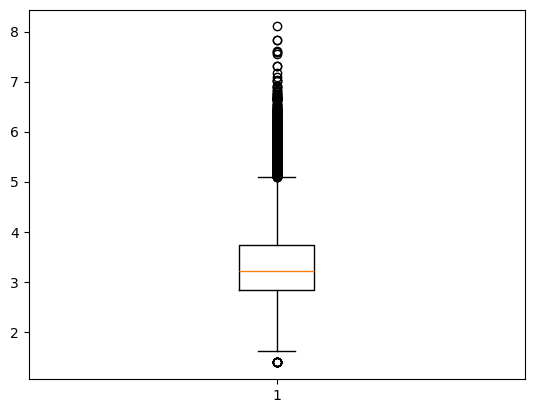

In [ ]:
wine_df = pd.read_csv("data/wines.csv")

## keep only wines whose price is not NaN
wine_df = wine_df[wine_df['price'].notna()]

print(wine_df.shape)

## key variables: price, description
for i in range(3):
    print("Description: ", wine_df['description'].iloc[i])
    print("Price: ", wine_df['price'].iloc[i])

## find the wine with the highest price
max_price_idx = wine_df['price'].argmax()
print("Most expensive wine: ", wine_df['description'].iloc[max_price_idx])
print("Price: ", wine_df['price'].iloc[max_price_idx])

## make box-plot of prices
plt.boxplot(np.log(wine_df['price']))


In [41]:
class textClassDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.max_len = max_len

        self.tokens = tokenizer(df['description'].tolist(), return_tensors='pt', max_length=self.max_len, 
                                      padding='max_length', truncation=True) 
        self.price = torch.tensor(df['price'].to_numpy(), dtype=torch.float)

    def __len__(self):
        return len(self.price)
    
    def __getitem__(self, idx):
        
        input_ids = self.tokens['input_ids'][idx]
        attention_mask = self.tokens['attention_mask'][idx]
        price = self.price[idx]

        return input_ids, attention_mask, price

In [42]:
dataset = textClassDataset(wine_df, tokenizer, 128)

## split into train and test datasets
train_size = int(0.5 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print("training data size: " + str(len(train_dataset)))

## create dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

training data size: 60487


In [43]:
batch = next(iter(train_dataloader))

In [44]:
class BertRegressor(nn.Module):
    def __init__(self):
        super(BertRegressor, self).__init__()
        self.bert = bert_model

        ## for distilbert-base-uncased, hidden_size is 768
        self.layer1 = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_outputs[0][:, 0, :] # [CLS] token1 token2 ... this grabs [CLS] token

        x = self.layer1(pooled_output)
        x = x.squeeze(1)
        return x
    

In [45]:
model = BertRegressor()

In [ ]:
## We can freeze bert parameters so that we only update the
## prediction head
# for param in model.bert.parameters():
#     param.requires_grad = False

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                             lr=1e-4)

num_epochs = 1

model.train()

#### Training

* 1 epoch of training takes about 20 mins.
* You can skip the training to directly load from the saved model parameter file.

In [ ]:
it = 0

for epoch in range(num_epochs):

    for batch in train_dataloader:

        input_ids = batch[0]
        attention_mask = batch[1]
        logprice = np.log(batch[2])

        pred = model(input_ids, attention_mask)
        loss = loss_fn(pred, logprice)
        loss.backward()
        optimizer.step()

        optimizer.zero_grad()
        
        it = it + 1
        if (it % 100 == 0):
            print("epoch: ", epoch, "sgd iter: " + str(it))
    print("Epoch: {}, Loss: {}".format(epoch, loss.item()))

In [ ]:
## save model parameters
torch.save(model.state_dict(), "model/fine-tuned-distilbert.pt")

In [ ]:
## load model
model.load_state_dict(torch.load("model/fine-tuned-distilbert.pt"))

<All keys matched successfully>

In [47]:
## calculate testing error
## takes about 2 minutes to run

model.eval()
mse = 0

n_test = 600

y_test = np.array([np.log(test_dataset[i][2]) for i in range(n_test)])

for i in range(n_test):
    pred = model(test_dataset[i][0].unsqueeze(0), test_dataset[i][1].unsqueeze(0))
    mse = mse + (pred - y_test[i])**2

mse = mse / n_test

print("MSE:", mse.item(), "  Test R-squared:", 1 - mse.item() / np.var(y_test))

/var/folders/f0/m7l23y8s7p3_0x04b3td9nyjr2hyc8/T/ipykernel_6343/1264298161.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y_test = np.array([np.log(test_dataset[i][2]) for i in range(n_test)])


MSE: 0.21289405226707458   Test R-squared: 0.4635502


In [48]:
## 

my_reviews = ["This white is both sour and bitter; it has a funny smell",
                "the most amazing wine I have ever tasted",
                "not bad at all; I would buy it again",
                "actually quite bad; avoid if possible",
                "great red and pretty cheap",
                "great red but overpriced",
                "great red and great price"]

for my_review in my_reviews:

    token_res = tokenizer(my_review, return_tensors='pt')

    pred = model(token_res['input_ids'], token_res['attention_mask'])
    
    print("My Description:", my_review)
    print("Predicted price: ", torch.exp(pred).item(), '\n')

My Description: This white is both sour and bitter; it has a funny smell
Predicted price:  15.726286888122559 

My Description: the most amazing wine I have ever tasted
Predicted price:  47.7934684753418 

My Description: not bad at all; I would buy it again
Predicted price:  12.506088256835938 

My Description: actually quite bad; avoid if possible
Predicted price:  14.870586395263672 

My Description: great red and pretty cheap
Predicted price:  12.206925392150879 

My Description: great red but overpriced
Predicted price:  24.468101501464844 

My Description: great red and great price
Predicted price:  12.49232006072998 



## Resources 

- [Text Classification with BERT](https://medium.com/@khang.pham.exxact/text-classification-with-bert-7afaacc5e49b)
- [Hugging Face Tutorial](https://colab.research.google.com/drive/1pxc-ehTtnVM72-NViET_D2ZqOlpOi2LH?usp=sharing#scrollTo=SH_MAK-soD4F)
- [Tokenization discussion](https://stanford-cs324.github.io/winter2022/lectures/modeling/)